In [1]:
# do this to make sure no error creeps in
! [ -e /content ] && pip install -Uqq fastai 

In [2]:
# basic fastai import 
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
# making a path
path = Path('/kaggle/input/face-mask-dataset/data')
path.ls()

(#2) [Path('/kaggle/input/face-mask-dataset/data/without_mask'),Path('/kaggle/input/face-mask-dataset/data/with_mask')]

In [4]:
# defining a label function 
# for getting labels form file name
def label_func(fname):
    label = str(fname).split('_')[0].split('/')[-1]
    
    if label == 'without':
        return 'without_Mask'
    else:
        return 'with_Mask'


# getting image file names
fnames = get_image_files(path)

# defining our data block
# this takes care of loading data 
# for us
block = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

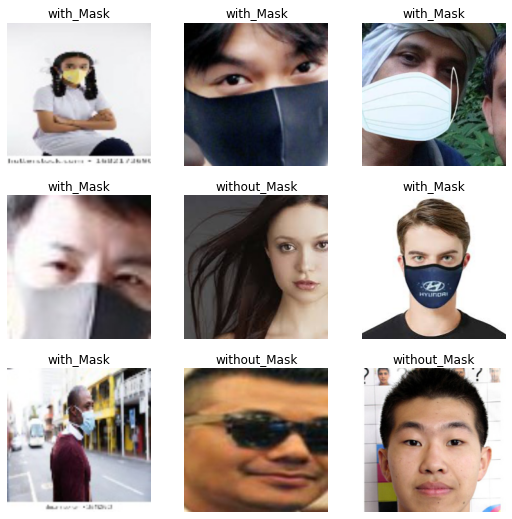

In [5]:
# now loading data
dls = block.dataloaders(path, bs = 32, item_tfms = RandomResizedCrop(460),
                       batch_tfms = [*aug_transforms(size = 224, max_warp =0), Normalize.from_stats(*imagenet_stats)])
dls.show_batch()

And we have loaded our data easy peazy

In [6]:
# lets check vocab
dls.vocab

['with_Mask', 'without_Mask']

# Training Model

In [7]:
# lets now train a very simple model
# lets make a learner first
learn = cnn_learner(dls, models.resnet34, pretrained = True, metrics = [error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [8]:
# lets train our leaner for 5 cycles
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.157848,0.034291,0.010596,0.989404,00:47
1,0.064949,0.009887,0.003311,0.996689,00:37
2,0.026185,0.005960,0.001987,0.998013,00:37
3,0.022690,0.007194,0.001325,0.998676,00:37
4,0.022353,0.006908,0.001987,0.998013,00:37


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency e

In [9]:
'''
performance display function 
copied from
https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
'''

from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    


# Model Evaluation

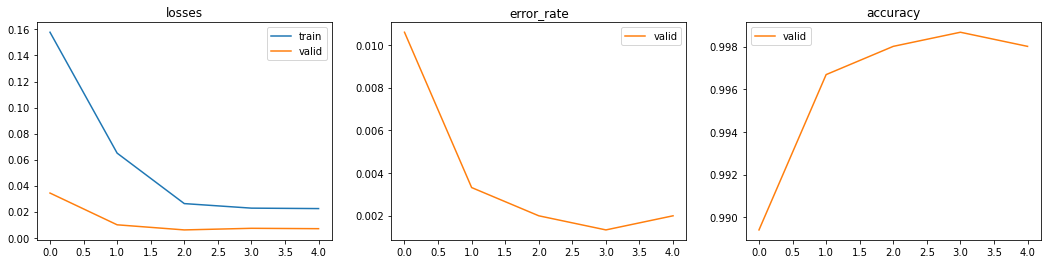

In [10]:
# Plotting matrics 
learn.recorder.plot_metrics()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


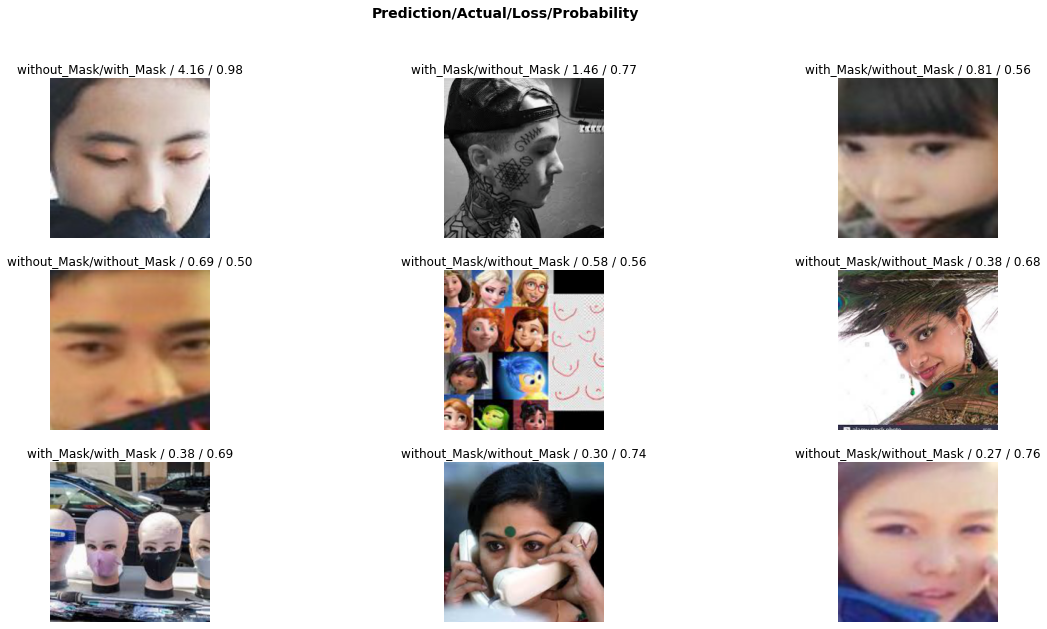

In [11]:
# plotting top losses
interperter = ClassificationInterpretation.from_learner(learn)
interperter.plot_top_losses(9, figsize = (20, 10))

In [12]:
learn.save('maskDetector')
#help(learn.save)

Path('models/maskDetector.pth')

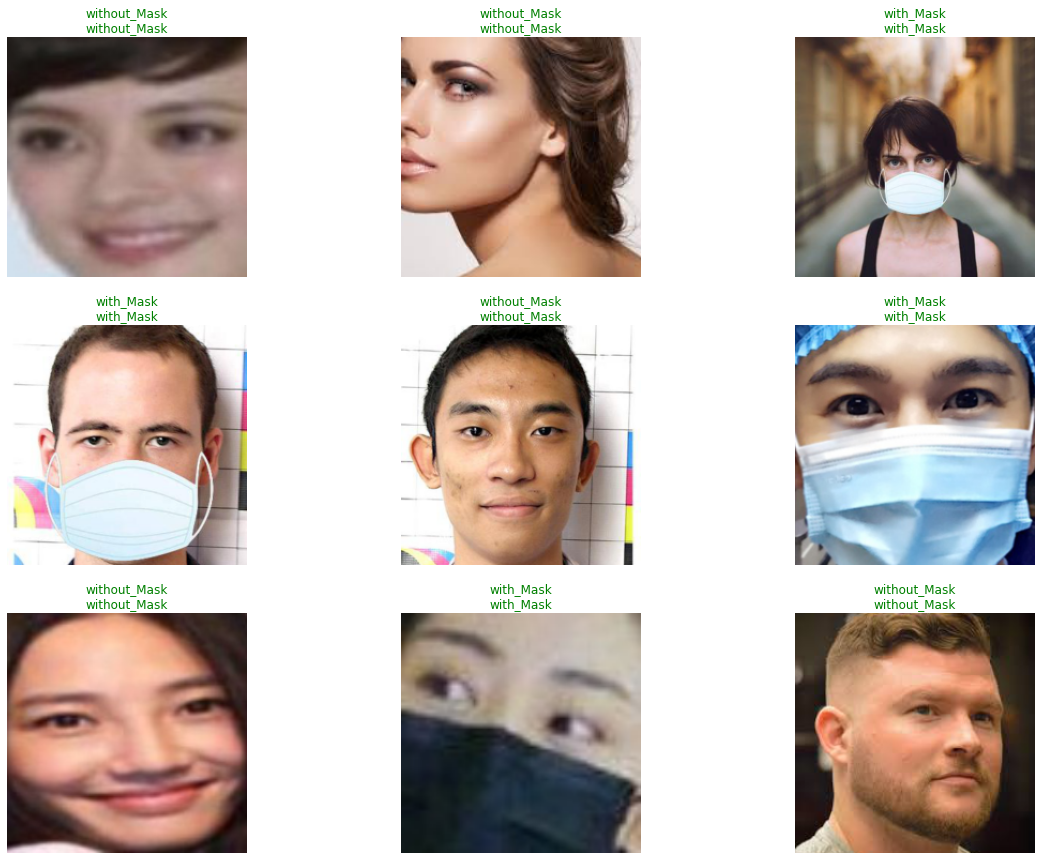

In [13]:
learn.show_results(figsize = (20, 15))